<a href="https://colab.research.google.com/github/andrejadikic/FileLocalImpl/blob/main/Domaci1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Zadatak 1

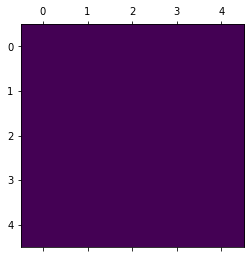

In [6]:
import threading
import random
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML

values = [0,1]
n = 5
#state je trenutno stanje matrice
#state = np.random.choice(values, n*n).reshape(n,n)
state = np.zeros((n, n)).astype(np.int8)
state[1][2]=1;
state[2][2]=1;
state[3][2]=1;
steps = [state]


#steps je matrica stanja koja pamti promenu stanja od iteracije do iteracije
#steps = [(np.random.rand(n**2).reshape(n, n) > 0.5).astype(np.int8)for i in range(n)]

#readcounters je brojac suseda koji su procitali trenutnu vrednost kad dodje do 8 onda se menja vrednost celije
readcounters = np.zeros((n, n)).astype(np.int8)
#cell_lock_counter za state da se menja 
cell_lock_counter = np.array([threading.Lock() for i in range(n*n)]).reshape(n,n)
# matrica key za readcounter
read_key = np.array([threading.Lock() for i in range(n*n)]).reshape(n,n)
# iter_lock je lock za sledecu iteraciju
iter_lock = threading.Lock()
# iter_counter broji koliko celija je uslo u cekaonicu
iter_counter = 0
# finish_counter koliko je izaslo iz 
finish_counter = n*n
#state = [(np.random.rand(n*n).reshape(n,n)>0.5).astype(np.int8)]

cond = 1

cond_key = threading.Lock()
wake_key = threading.Lock()

def wakeUp(x,y):
    global n
    global cell_lock_counter
    global readcounters
    global cell_lock_counter

    if( ((x==0 or x==n) and (y>0 and y<n)) or ((y==0 or y==n) and (x>0 and x<n)) ) and readcounters[x][y]==5:
      cell_lock_counter[x][y].release
      read_key[x][y].acquire
      readcounters[x][y]=0
      read_key[x][y].release
      return 1
    elif (x==0 or x==n) and (y==0 or y==n) and readcounters[x][y]==3:
      cell_lock_counter[x][y].release
      read_key[x][y].acquire
      readcounters[x][y]=0
      read_key[x][y].release
      return 1
    return 0

def getValue(x,y):
    global n
    global state
    global read_key
    global readcounters

    if (x>=0 and x<n and y>=0 and y<n):
      read_key[x][y].acquire
      readcounters[x][y] += 1
      read_key[x][y].release
      wakeUp(x,y)
      return state[x][y]
    return 0;


def count_alive_cells(curr_x, curr_y):
    alive_cells = 0
    global n
    cordinates = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]

    for i,j in cordinates:
      alive_cells += getValue(curr_x+i,curr_y+j)

    wakeUp(curr_x,curr_y)
    return alive_cells

def isAlive(curr_val,alive_neigbors):
    if(alive_neigbors<2 or alive_neigbors>3):
      return 0
    elif((alive_neigbors==2 or alive_neigbors==3) and curr_val==1) or (curr_val==0 and alive_neigbors==3):
      return 1
    return curr_val

def copyState(s):
  states = []
  states = s.copy()
  return states

def playGame(x,y):
    global n
    global steps
    global state
    global finish_counter # koliko su izasli iz cekaonice
    global iter_lock
    global iter_counter # koliko su usli u cekaonicu
    global cond # uslov
    global cell_lock_counter #lock[x][y] za state da se menja state[x][y]
    global cond_key
    global wake_key

    count = count_alive_cells(x,y)
    newState = isAlive(state[x][y],count)


    if(iter_counter==0 and finish_counter==n*n and cond==1):  # prva nit ulazi u cekaonicu
      steps.append(copyState(state))
      iter_lock.acquire
      iter_counter+=1
      iter_lock.release
      cond=0
      cond_key.acquire
      
    elif(iter_counter==n*n): # poslednja nit
      cell_lock_counter[x][y].acquire
      if(wakeUp(x,y)==1):
        state[x][y] = newState;
      iter_counter = 0
      cond=1
      cond_key.release
      finish_counter=1
    else: # ni jedna ni druga
      iter_counter+=1
      
      cond_key.acquire
      if(cond):
        cell_lock_counter[x][y].acquire
        state[x][y] = newState;
        finish_counter+=1
        cond_key.release


def animate(steps):
  ''' Prima niz matrica (svaka matrica je stanje u jednom koraku simulacije) 
  prikazuje razvoj sistema'''
  
  def init():
    im.set_data(steps[0])
    return [im]
  
  
  def animate(i):
    im.set_data(steps[i])
    return [im]

  im = plt.matshow(steps[0], interpolation='None', animated=True);
  
  anim = FuncAnimation(im.get_figure(), animate, init_func=init,
                  frames=len(steps), interval=500, blit=True, repeat=False);
  return anim


threads=[]

for k in range(5):
  for i in range(n):
    for j in range(n):
      t = threading.Thread(target=playGame, args=(i,j))
      t.start()
      threads.append(t)

for t in threads:
  t.join()

anim = animate(steps)
HTML(anim.to_html5_video())

Zadatak 2